In [1]:
import numpy as np
import pandas as pd
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import silhouette_score
import yfinance as yf
import time
import glob
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

In [2]:
# path to folder containing csv files. Each files correspond to an asset (stock)
folder_path = os.path.join("stocks", "datasets","dj30","raw", "*.csv")
csv_files = glob.glob(folder_path)
data_frames = []

for file in csv_files:
    # each file name is the stock symbol, so we simply extract sticker from the file's name
    symbol = os.path.splitext(os.path.basename(file))[0]
    print(f"processing {symbol} from {file}...")
    
    # parse "Date" column and filter the desired timeline (range). To be updated later !!!(problem with yahoo"s API)
    df = pd.read_csv(file, parse_dates=['Date'])
    #df = df.loc[~df.index.duplicated(keep='first')]
    mask = (df['Date'] >= '2010-01-01') & (df['Date'] <= '2018-12-21')
    df = df.loc[mask]
    # we only consider "Date" and "Adj Close" columns
    df = df[['Date', 'Adj Close']].set_index('Date')
    df.rename(columns={'Adj Close': symbol}, inplace=True)
    data_frames.append(df)

merged_df = pd.concat(data_frames, axis=1)
merged_df.sort_index(inplace=True)
print(merged_df.head())

processing CSCO from stocks/datasets/dj30/raw/CSCO.csv...
processing BA from stocks/datasets/dj30/raw/BA.csv...
processing V from stocks/datasets/dj30/raw/V.csv...
processing WBA from stocks/datasets/dj30/raw/WBA.csv...
processing MRK from stocks/datasets/dj30/raw/MRK.csv...
processing PG from stocks/datasets/dj30/raw/PG.csv...
processing CAT from stocks/datasets/dj30/raw/CAT.csv...
processing MCD from stocks/datasets/dj30/raw/MCD.csv...
processing INTC from stocks/datasets/dj30/raw/INTC.csv...
processing MMM from stocks/datasets/dj30/raw/MMM.csv...
processing KO from stocks/datasets/dj30/raw/KO.csv...
processing MSFT from stocks/datasets/dj30/raw/MSFT.csv...
processing HD from stocks/datasets/dj30/raw/HD.csv...
processing AXP from stocks/datasets/dj30/raw/AXP.csv...
processing CVX from stocks/datasets/dj30/raw/CVX.csv...
processing NKE from stocks/datasets/dj30/raw/NKE.csv...
processing IBM from stocks/datasets/dj30/raw/IBM.csv...
processing GS from stocks/datasets/dj30/raw/GS.csv...


In [9]:
log_returns = np.log(merged_df / merged_df.shift(1)).dropna()
window_size = 120 # as in the paper
correlation_matrices = []
for start in range(0, len(log_returns) - window_size + 1, window_size):
    window_data = log_returns.iloc[start:start+window_size]
    corr_matrix = window_data.corr().values
    correlation_matrices.append(corr_matrix)
n_assets = log_returns.shape[1]
features = [mat[np.triu_indices(n_assets, k=1)] for mat in correlation_matrices]
features = np.array(features)

#########################elbow, silhouette, and gap stat methods to determine the optimal 'k'#####################

# WSS for elbow 
def wss_f(X, labels):
    wss = 0
    for label in np.unique(labels):
        cluster_points = X[labels == label]
        centroid = cluster_points.mean(axis=0)
        wss += np.sum((cluster_points - centroid) ** 2)
    return wss

# gap stat
def gap_stat(X, nrefs=20, maxClusters=10):
    shape = X.shape
    tops = X.max(axis=0)
    bottoms = X.min(axis=0)
    refs = np.zeros((nrefs, shape[0], shape[1]))
    
    for i in range(nrefs):
        refs[i] = np.random.uniform(low=bottoms, high=tops, size=shape)
    
    gaps = np.zeros(maxClusters)
    sk = np.zeros(maxClusters)
    for k in range(1, maxClusters + 1):
        # we proceed via hierarchical clustering
        Z = linkage(X, method='ward')
        labels = fcluster(Z, t=k, criterion='maxclust')
        orig_wss = wss_f(X, labels)
        ref_wss = np.zeros(nrefs)
        
        for i in range(nrefs):
            Z_ref = linkage(refs[i], method='ward')
            labels_ref = fcluster(Z_ref, t=k, criterion='maxclust')
            ref_wss[i] = wss_f(refs[i], labels_ref)
        gap_values = np.log(np.mean(ref_wss)) - np.log(orig_wss)
        gaps[k - 1] = gap_values
        sk[k - 1] = np.sqrt(np.mean((np.log(ref_wss) - np.mean(np.log(ref_wss)))**2)) * np.sqrt(1 + 1.0/nrefs)
    return gaps, sk

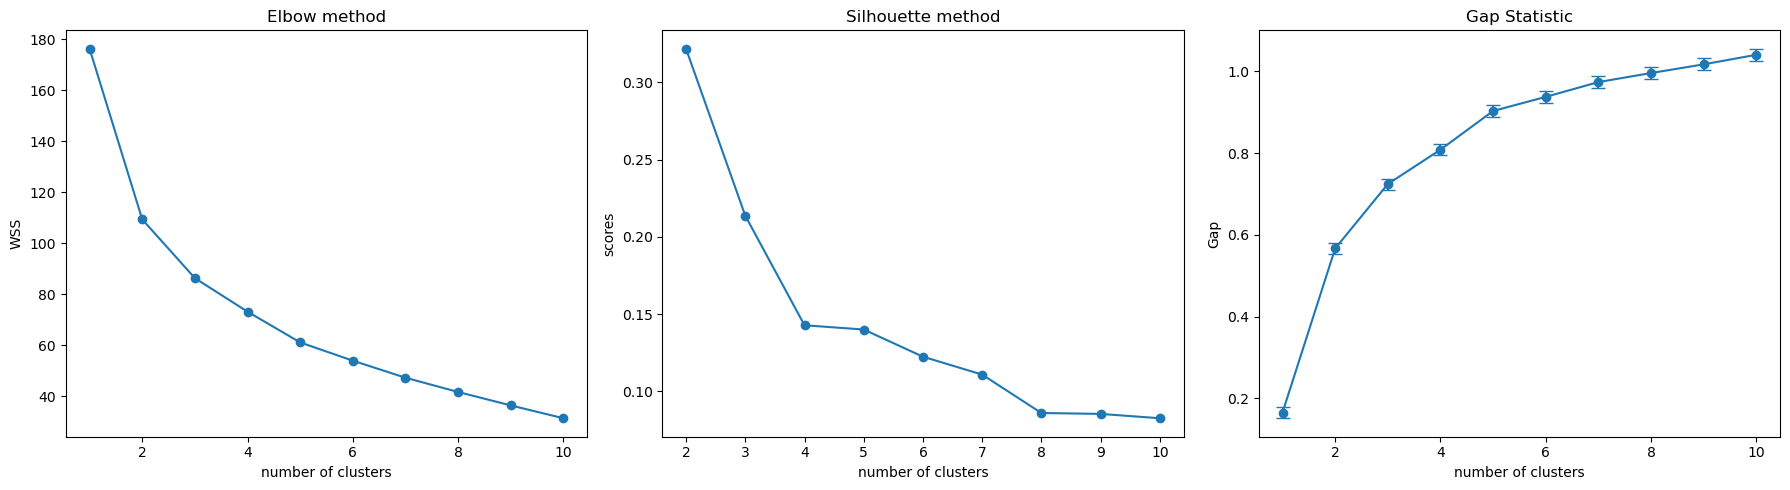

In [11]:
# evaluation on k=10
max_clusters = 10
cluster_range = np.arange(1, max_clusters + 1)
wss_vec = []
silhouette_vec = []

for k in cluster_range:
    Z = linkage(features, method='ward')
    labels = fcluster(Z, t=k, criterion='maxclust')
    wss = wss_f(features, labels)
    wss_vec.append(wss)
    
    # for silhouette score (always k>=2)
    if k > 1:
        score = silhouette_score(features, labels)
        silhouette_vec.append(score)
    else:
        silhouette_vec.append(np.nan)

gaps, sk = gap_stat(features, nrefs=20, maxClusters=max_clusters) # gap statistic for each k

# plot
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# elbow
ax[0].plot(cluster_range, wss_vec, marker='o')
ax[0].set_title("Elbow method")
ax[0].set_xlabel("number of clusters")
ax[0].set_ylabel("WSS")
#silhouette 
ax[1].plot(cluster_range, silhouette_vec, marker='o')
ax[1].set_title("Silhouette method")
ax[1].set_xlabel("number of clusters")
ax[1].set_ylabel("scores")
# 3. gap stat
ax[2].errorbar(cluster_range, gaps, yerr=sk, marker='o', capsize=5)
ax[2].set_title("Gap Statistic")
ax[2].set_xlabel("number of clusters")
ax[2].set_ylabel("Gap")

plt.tight_layout()
plt.show()